# Подбор параметров ядра #

*Какие-то вводные слова*

In chapters 2 and 3 we have seen how to do regression and classification using a Gaussian process with a given fixed covariance function. However, in many practical applications, it may not be easy to specify all aspects of the covariance function with confidence. While some properties such as stationarity of the covariance function may be easy to determine from the context, we typically have only rather vague information about other properties, such as the value of free (hyper-) parameters, e.g. length-scales. In chapter 4 several examples of covariance functions were presented, many of which have large numbers of parameters. In addition, the exact form and possible free parameters of the likelihood function may also not be known in advance. Thus in order to turn Gaussian processes into powerful practical tools it is essential to develop methods that address the model selection problem. We interpret the model selection problem rather broadly, to include all aspects of the model including the discrete choice of the functional form for the covariance function as well as values for any hyperparameters.

В главах 2 и 3 мы видели, как делать регрессию и классификацию, используя гауссовский процесс с заданной фиксированной ковариационной функцией. Однако во многих практических приложениях может быть нелегко с уверенностью указать все аспекты ковариационной функции. Хотя некоторые свойства, такие как стационарность ковариационной функции, могут быть легко определены из контекста, мы обычно имеют лишь достаточно расплывчатую информацию о других свойствах, например, о значении свободных (гипер-) параметров, например, о длинах. В главе 4 было представлено несколько примеров ковариационных функций, многие из которых имеют большое количество параметров. Кроме того, точная форма и возможные свободные параметры вероятностной функции также могут быть неизвестны заранее. Таким образом, для того, чтобы превратить гауссовские процессы в мощный практический инструмент, необходимо разработать методы, решающие проблему выбора модели. Мы достаточно широко интерпретируем проблему выбора модели, чтобы включить в нее все аспекты модели, в том числе и дискретные выбор функциональной формы для ковариационной функции, а также значения для любых гиперпараметров.

In [23]:
# Imports
import numpy as np

import matplotlib
from matplotlib import cm # Colormaps
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.size'] = 12
sns.set_style('whitegrid')
np.random.seed(42)

## Влияние параметров ядра и амплитуды шума ##

### Используемые функции ###

На предыдущих занятиях мы использовали квадратичное экспоненциальное ядро:

$$ k(x_a, x_b) = \sigma_f^2 \exp{ \left( -\frac{1}{2l^2} \lVert x_a - x_b \rVert^2 \right) }. $$

Теперь пришло время поиграть с параметрами ядра: ширины ядра $l$ и амплитуды $\sigma_f$.

Ниже приводятся уже знакомые нам функции `kernel()`, `plot_gp()` и `posterior_predictive()`.

In [24]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [25]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(
        X, mu + uncertainty, mu - uncertainty,
        color='grey', alpha=0.1, label='95% доверительный интервал')
    for sample in enumerate(samples):
        plt.plot(X, sample, '-', lw=1.0)
    plt.plot(X, mu, label='среднее значение')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'x', c=cm.tab10(3), mew=1.5)
    plt.xlim([X.min(), X.max()])

In [26]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffiсient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # mean vector
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # covariance matrix
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

### Тренировочные данные ###

В качестве обучающей выборки будем использовать данные из предыдущего занятия.

In [27]:
# Data
x_min, x_max = 0., 10.
N_test = 1001
X_test = np.linspace(x_min, x_max, N_test).reshape(-1,1)

X_train = np.array([2.,  6.,  7., 8.,  4., 3. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1., 0.5]).reshape(-1, 1)

### Варьирование параметров ядра и амплитуды шума ###

В следующем примере показано влияние параметров ядра $l$ и $\sigma_f$, а также амплитуды шума $\sigma_y$.По рисункам можно сделать следующие выводы:

1. Малое значения $l$ приводит к достаточно &laquo;изогнутой&raquo; средней функции с большими доверительными интервалами между точками обучающей выборки.
Большое значение ширины ядра $l$ даёт более гладкую регрессионную функцию, но более грубую аппроксимацию обучающих данных.
2. Параметр $\sigma_f$ контролирует вертикальную вариативность функций, взятых из GP.
Это видно по большим доверительным интервалам за пределами области тренировочных данных на правом рисунке второй строки.
3. Параметр $\sigma_y$ представляет собой уровень шума в обучающих данных.
Более высокое значение $\sigma_y$ приводит к более грубой аппроксимации, но позволяет избежать подгонки под шумные данные.

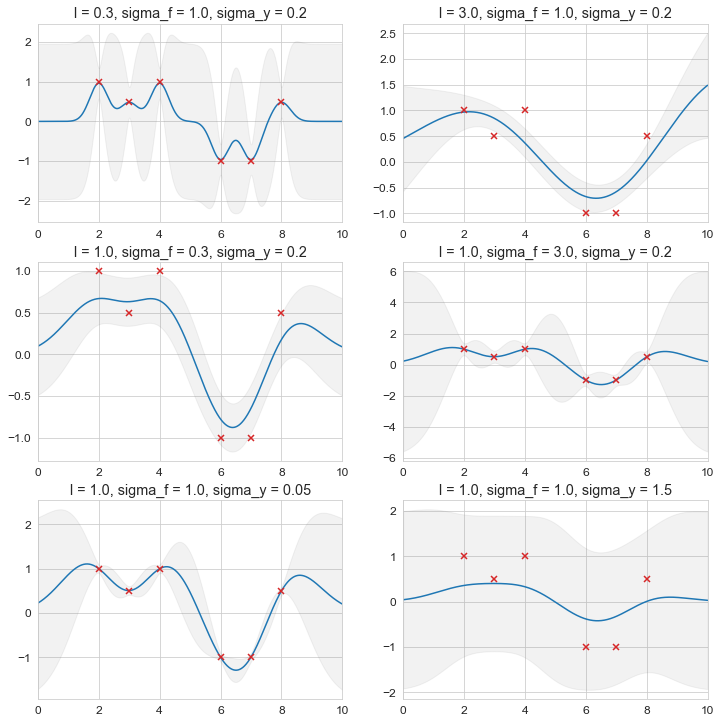

In [28]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(
        X_test, X_train, Y_train,
        l=l, sigma_f=sigma_f, sigma_y=sigma_y)
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

## Оптимизация параметров ядра ##

Оптимальные значения параметров ядра (гиперпарамтров) могут быть оценены путём максимизации логарифма правдободобия.

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{7}
$$

Минимизируем отрицательную маржинальную вероятность относительно параметров $l$ и $\sigma_f$, при известном уровне шума данных $\sigma_y$.
Если уровень шума неизвестен, то наряду с другими параметрами можно оценить и $\sigma_y$. 

In [29]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in RW2, Section 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

l_opt = 0.97, sigma_f_opt = 0.7, noise = 0.5


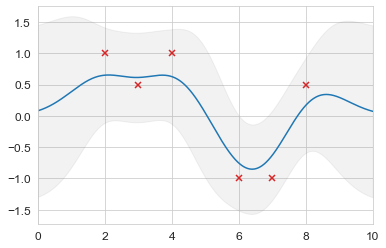

In [30]:
# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
noise = 0.5
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
print(
    f'l_opt = {res.x[0]:.2}, sigma_f_opt = {res.x[1]:.2}, '\
    f'noise = {noise:.2}')

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(
    X_test, X_train, Y_train,
    l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise
)
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

---

In [31]:
def nll_fn_2(X_train, Y_train, naive=True):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            theta[2]**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in RW2, Section 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            theta[2]**2 * np.eye(len(X_train))
        L = cholesky(K)
        LL = lstsq(L, Y_train, rcond=None)[0]
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, LL, rcond=None)[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

l_opt = 0.77, sigma_f_opt = 0.86, sigma_y_opt = 2.3e-05


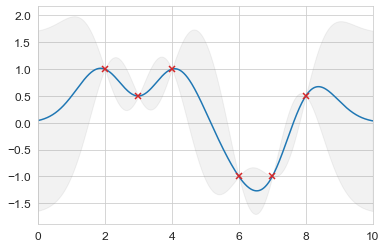

In [32]:
# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn_2(X_train, Y_train, naive=False), [1, 1, 0.1], 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt, sigma_y_opt = res.x
print(
    f'l_opt = {res.x[0]:.2}, sigma_f_opt = {res.x[1]:.2}, '\
    f'sigma_y_opt = {res.x[2]:.2}')

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(
    X_test, X_train, Y_train,
    l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_y_opt
)
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

With optimized kernel parameters, training data are reasonably covered by the 95% confidence interval and the mean of the posterior predictive is a good approximation.

При оптимизированных параметрах ядра обучающие данные разумно покрываются 95% доверительным интервалом, а среднее апостериорное предсказание является хорошей аппроксимацией.

### Higher dimensions

### Более высокие размеры

The above implementation can also be used for higher input data dimensions. Here, a GP is used to fit noisy samples from a sine wave originating at $\boldsymbol{0}$ and expanding in the x-y plane. The following plots show the noisy samples and the posterior predictive mean before and after kernel parameter optimization.

Вышеприведенная реализация может также использоваться для более высоких размеров входных данных. Здесь GP используется для подгонки шумных отсчетов из синусоидальной волны, идущей от $\boldsymbol{0}$ и расширяющейся в плоскости x-y. На следующих графиках показаны шумные выборки и заднее предиктивное среднее до и после оптимизации параметров кернела.

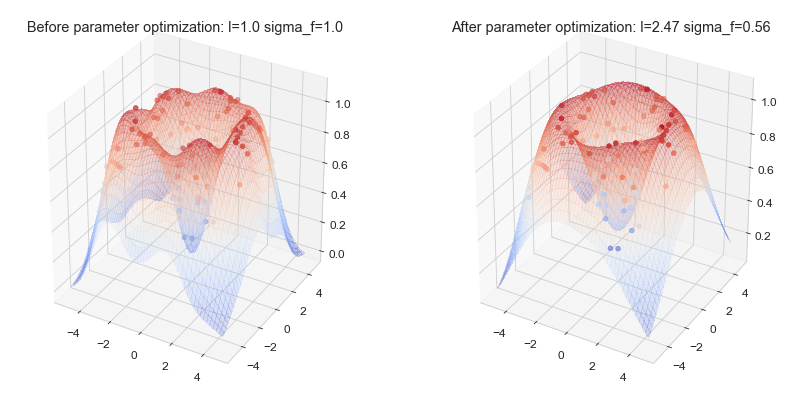

In [64]:
from gaussian_processes_util import plot_gp_2D

noise_2D_train = 0.03
noise_2D_model = 0.10

rx, ry = np.arange(-5, 5, 0.2), np.arange(-5, 5, 0.2)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D_train * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D_model)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D_model), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D_model)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

Note how the true sine wave is approximated much better after parameter optimization.

Обратите внимание, что истинная синусоидальная волна аппроксимируется намного лучше после оптимизации параметров.

## Libraries that implement GPs

## Библиотеки, реализующие GP.

This section shows two examples of libraries that provide implementations of GPs. I'll provide only a minimal setup here, just enough for reproducing the above results. For further details please consult the documentation of these libraries.

В этом разделе показаны два примера библиотек, предоставляющих реализацию GP. Здесь я предоставлю лишь минимальную настройку, достаточную для воспроизведения вышеуказанных результатов. За более подробной информацией обращайтесь к документации этих библиотек.

### Scikit-learn

Scikit-learn provides a `GaussianProcessRegressor` for implementing [GP regression models](http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr). It can be configured with [pre-defined kernels and user-defined kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels). Kernels can also be composed. The squared exponential kernel is the `RBF` kernel in scikit-learn. The `RBF` kernel only has a `length_scale` parameter which corresponds to the $l$ parameter above. To have a $\sigma_f$ parameter as well, we have to compose the `RBF` kernel with a `ConstantKernel`.

Scikit-learn предоставляет `GaussianProcessRegressor` для реализации моделей регрессии GP. Он может быть сконфигурирован с предопределенными ядрами и пользовательскими ядрами. Ядра также могут быть скомпонованы. Квадратное экспоненциальное ядро - это `RBF` ядро в scikit-learn. Ядро `RBF` имеет только параметр `length_scale`, который соответствует указанному выше параметру $l$. Чтобы также иметь параметр $\sigma_f$, нужно составить ядро `RBF` с `ConstantKernel`.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

### GPy

[GPy](http://sheffieldml.github.io/GPy/) is a Gaussian processes framework from the Sheffield machine learning group. It provides a `GPRegression` class for implementing GP regression models. By default, `GPRegression` also estimates the noise parameter $\sigma_y$ from data, so we have to `fix()` this parameter to be able to reproduce the above results.

In [ ]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize();

# Display optimized parameter values
display(gpr)

In [ ]:
# Obtain optimized kernel parameters
l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results with the built-in plot function
gpr.plot();

Thanks for reading up to here :-) In another article, I'll show how Gaussian processes can be used for black-box optimization.

## References

\[1\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 4, 14 and 15.  
\[2\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapter 6.  
\[3\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  